In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.add("PyPlot"); Pkg.add("ForwardDiff"); Pkg.instantiate()

  Activating project at `/workspaces/lecture-notebooks/Lecture 2`
   Resolving package versions...
  No Changes to `/workspaces/lecture-notebooks/Lecture 2/Project.toml`
  No Changes to `/workspaces/lecture-notebooks/Lecture 2/Manifest.toml`
   Resolving package versions...
  No Changes to `/workspaces/lecture-notebooks/Lecture 2/Project.toml`
  No Changes to `/workspaces/lecture-notebooks/Lecture 2/Manifest.toml`


In [2]:
using LinearAlgebra
using PyPlot
using ForwardDiff

In [3]:
function pendulum_dynamics(x)
    l = 1.0
    g = 9.81
    
    θ = x[1]
    θ̇ = x[2]
    
    θ̈ = -(g/l)*sin(θ)
    
    return [θ̇; θ̈]
end

pendulum_dynamics (generic function with 1 method)

In [4]:
function pendulum_forward_euler(fun, x0, Tf, h)    
    t = Array(range(0,Tf,step=h))
    
    x_hist = zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        x_hist[:,k+1] .= x_hist[:,k] + h*fun(x_hist[:,k])
    end
    
    return x_hist, t
end

pendulum_forward_euler (generic function with 1 method)

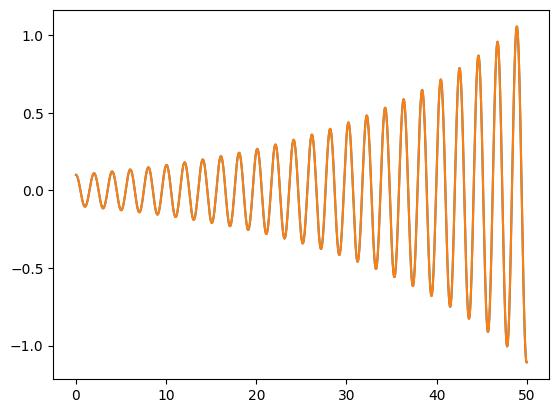

In [6]:
x0 = [.1; 0]
x_hist1, t_hist1 = pendulum_forward_euler(pendulum_dynamics, x0, 50, .01)
plot(t_hist1, x_hist1[1,:])
display(gcf())

In [8]:
function pendulum_euler_Ad(x0, h)
    g = 9.81
    Ad = [1 h; -g*h*cos(x0[1]) 1]
end

pendulum_euler_Ad (generic function with 1 method)

In [9]:
eigvals(pendulum_euler_Ad(0, 0.001))

2-element Vector{ComplexF64}:
 1.0 - 0.0031320919526731652im
 1.0 + 0.0031320919526731652im

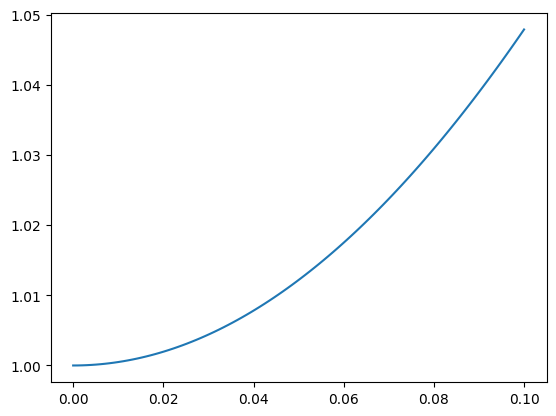

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ca32741e9c0>

In [10]:
eignorm = zeros(100)
h = LinRange(0,0.1,100)
for k = 1:length(eignorm)
    eignorm[k] = max(norm.(eigvals(pendulum_euler_Ad([0;0], h[k])))...)
end
plot(h,eignorm)

In [11]:
function fd_pendulum_rk4(xk, h)
    f1 = pendulum_dynamics(xk)
    f2 = pendulum_dynamics(xk + 0.5*h*f1)
    f3 = pendulum_dynamics(xk + 0.5*h*f2)
    f4 = pendulum_dynamics(xk + h*f3)
    return xk + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

fd_pendulum_rk4 (generic function with 1 method)

In [12]:
function pendulum_rk4(fun, x0, Tf, h)    
    t = Array(range(0,Tf,step=h))
    
    x_hist = zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        x_hist[:,k+1] .= fd_pendulum_rk4(x_hist[:,k], h)
    end
    
    return x_hist, t
end

pendulum_rk4 (generic function with 1 method)

In [ ]:
x0 = [.1; 0]
x_hist2, t_hist2 = pendulum_rk4(pendulum_dynamics, x0, 100, 0.01)
plot(t_hist2, x_hist2[1,:])

In [13]:
using ForwardDiff
Ad = ForwardDiff.jacobian(x -> fd_pendulum_rk4(x, 0.01), [0; 0])
norm.(eigvals(Ad))

2-element Vector{Float64}:
 0.9999999999934447
 0.9999999999934447

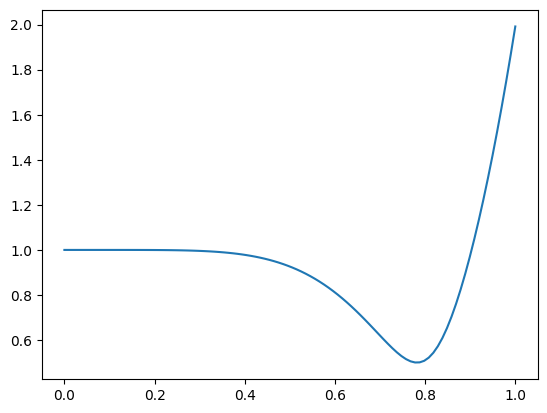

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ca349101ca0>

In [14]:
eignorm = zeros(100)
h = LinRange(0,1,100)
for k = 1:length(eignorm)
    eignorm[k] = max(norm.(eigvals(ForwardDiff.jacobian(x -> fd_pendulum_rk4(x, h[k]), [0; 0])))...)
end
plot(h,eignorm)

In [24]:
function backward_euler_step(fun, xk, dt; tol=1e-8, maxiter=100)
    x_next = copy(xk)
    e = 1.0
    iter = 0
    while e > tol && iter < maxiter
        xn = xk + dt .* fun(x_next)
        e = norm(xn - x_next)
        x_next .= xn
        iter += 1
    end
    if iter == maxiter
        println("Warning: Maximum iterations reached in backward Euler step.")
    end
    if e > tol
        println("Warning: Convergence not achieved in backward Euler step.")
        error("后向欧拉未收敛:dt:$(dt).e:$(e)")
    end
    return x_next
end

function pendulum_backward_euler(fun, x0, Tf, dt)
    t = Array(range(0, Tf, step=dt))
    x_hist = zeros(length(x0), length(t))
    x_hist[:, 1] .= x0
    for k = 1:(length(t)-1)
        x_hist[:, k+1] .= backward_euler_step(fun, x_hist[:, k], dt)
    end
    return x_hist, t
end

pendulum_backward_euler (generic function with 1 method)

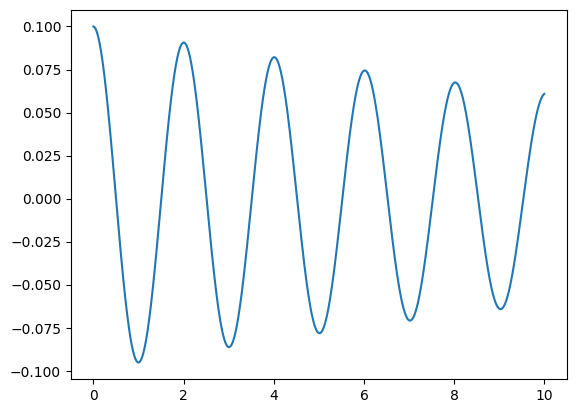

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ca348f33740>

In [23]:
x0 = [.1; 0]
x_hist3, t_hist3 = pendulum_backward_euler(pendulum_dynamics, x0, 10, 0.01)
plot(t_hist3, x_hist3[1,:])

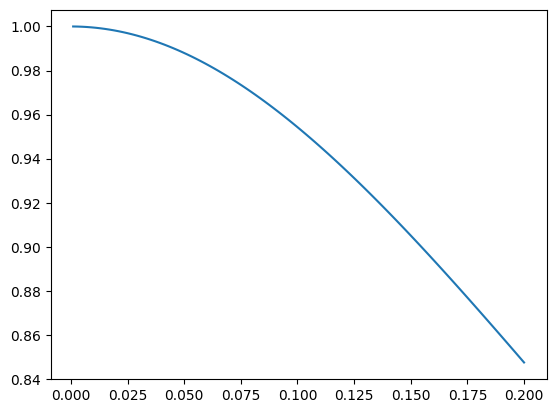

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ca326e023f0>

In [27]:
# 画图展示后向欧拉法的特征值随步长变化的趋势
using LinearAlgebra
using ForwardDiff

function backward_euler_Ad(x0, h)
    g = 9.81
    # 雅可比矩阵的近似（隐式欧拉的离散化）
    # x_{k+1} = x_k + h * f(x_{k+1})
    # 线性化: x_{k+1} ≈ x_k + h * A * x_{k+1}，A = df/dx
    A = ForwardDiff.jacobian(pendulum_dynamics, x0)
    Ad = inv(I - h*A)
    return Ad
end

hvals = LinRange(0.001, 0.2, 100)
eignorm = zeros(length(hvals))
for k = 1:length(hvals)
    Ad = backward_euler_Ad([0.0; 0.0], hvals[k])
    eignorm[k] = maximum(norm.(eigvals(Ad)))
end

plot(hvals, eignorm)